Pipeline 1: Thu thập Dữ liệu và Tiền xử lý ban đầu

In [2]:
import sys
print(f"Using Python from: {sys.executable}")

# Import required packages with error handling
try:
    import os
    print("✓ os imported")
    
    import pandas as pd 
    print("✓ pandas imported")
    
    import sklearn
    from sklearn.preprocessing import LabelEncoder
    print("✓ sklearn imported")
    
    import tensorflow
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    print("✓ tensorflow imported")
    
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    print("✓ sklearn utils imported")
    
    # Import PyMuPDF correctly
    import fitz  # This imports PyMuPDF
    print("✓ PyMuPDF imported")

except ImportError as e:
    print(f"Import Error: {e}")
    print("Please run these commands in your terminal:")
    print("pip install scikit-learn pandas tensorflow PyMuPDF")
    raise

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    try:
        with fitz.open(pdf_path) as document:
            text = " ".join([page.get_text() for page in document])
        return text
    except Exception as e:
        print(f"Error extracting text from PDF: {e}")
        return None

Using Python from: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\venv\Scripts\python.exe
✓ os imported
✓ pandas imported
✓ sklearn imported
✓ tensorflow imported
✓ sklearn utils imported
✓ PyMuPDF imported


In [4]:
# Set the correct path to your PDF files
pdf_folder = "data/raw/cv/test"  # This is your actual folder path shown in VS Code

# Add error handling and logging
try:
    # Verify folder exists
    if not os.path.exists(pdf_folder):
        raise FileNotFoundError(f"Directory not found: {pdf_folder}")
    
    # Get list of PDF files only
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
    print(f"Found {len(pdf_files)} PDF files")

    # Extract text from PDFs
    data = []
    for pdf_file in pdf_files:
        full_path = os.path.join(pdf_folder, pdf_file)
        print(f"Processing: {pdf_file}")
        content = extract_text_from_pdf(full_path)
        if content:
            data.append({
                "filename": pdf_file,
                "content": content
            })

    # Create DataFrame and save to CSV
    output_file = "data/processed/cv/cv_texts.csv"
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"Successfully processed {len(data)} files")
    print(f"Output saved to: {output_file}")

except Exception as e:
    print(f"Error: {str(e)}")
    # Print current working directory for debugging
    print(f"Current working directory: {os.getcwd()}")

Found 706 PDF files
Processing: 10001727.pdf
Processing: 10276858.pdf
Processing: 10329506.pdf
Processing: 10333299.pdf
Processing: 10554236.pdf
Processing: 10588874.pdf
Processing: 10653119.pdf
Processing: 10674770.pdf
Processing: 10830646.pdf
Processing: 10889157.pdf
Processing: 10909673.pdf
Processing: 11065180.pdf
Processing: 11121498.pdf
Processing: 11163645.pdf
Processing: 11187796.pdf
Processing: 11209758.pdf
Processing: 11262933.pdf
Processing: 11266906.pdf
Processing: 11360471.pdf
Processing: 11432686.pdf
Processing: 11444536.pdf
Processing: 11555549.pdf
Processing: 11637468.pdf
Processing: 11672279.pdf
Processing: 11759079.pdf
Processing: 11773925.pdf
Processing: 11842348.pdf
Processing: 11995013.pdf
Processing: 12021752.pdf
Processing: 12065211.pdf
Processing: 12155206.pdf
Processing: 12202337.pdf
Processing: 12254068.pdf
Processing: 12334650.pdf
Processing: 12338274.pdf
Processing: 12386670.pdf
Processing: 12413512.pdf
Processing: 12420359.pdf
Processing: 12442909.pdf
Proce

In [11]:
import os
import re
import pandas as pd
from pathlib import Path
import fitz  # PyMuPDF
import logging

class CVProcessor:
    def __init__(self):
        # Setup logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

        # Setup paths - using direct paths instead of __file__
        self.base_dir = Path().absolute()  # Gets current working directory
        self.input_dir = self.base_dir / 'data' / 'raw' / 'cv' / 'test'
        self.output_dir = self.base_dir / 'data' / 'processed' / 'cv'
        
        # Create output directory if it doesn't exist
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        # Log paths
        self.logger.info(f"Input directory: {self.input_dir}")
        self.logger.info(f"Output directory: {self.output_dir}")

    # ... [rest of the class methods remain the same]

def main():
    try:
        # Initialize processor
        processor = CVProcessor()
        
        # Print working directory for debugging
        print(f"Current working directory: {Path().absolute()}")
        print(f"Looking for PDFs in: {processor.input_dir}")

        # Process CVs
        results = processor.process_cvs()

        # Save results
        processor.save_results(results)

        # Print summary
        print(f"\nProcessing Summary:")
        print(f"Total CVs processed: {len(results)}")
        print(f"Results saved to: {processor.output_dir / 'cv_processed.csv'}")

    except Exception as e:
        print(f"Error during processing: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")

if __name__ == "__main__":
    main()

2025-01-11 17:24:58,050 - INFO - Input directory: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\raw\cv\test
2025-01-11 17:24:58,054 - INFO - Output directory: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\processed\cv


Current working directory: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System
Looking for PDFs in: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\data\raw\cv\test
Error during processing: 'CVProcessor' object has no attribute 'process_cvs'
Current working directory: c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System


In [15]:
# Cell 4: Initialize models and process data
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Read processed CV data
df = pd.read_csv('data/processed/cv/cv_texts.csv')

# Print column names to debug
print("Available columns:", df.columns.tolist())

# Initialize preprocessing tools
le = LabelEncoder()
tokenizer = Tokenizer(num_words=5000)

# Process text data - use 'content' instead of 'processed_text'
texts = df['content'].values  # Assuming 'content' is the column name with CV text
texts_tokenized = tokenizer.texts_to_sequences(texts)  # Changed fit_transform to texts_to_sequences
X = pad_sequences(texts_tokenized, maxlen=100)

print(f"Processed {len(texts)} documents")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Input shape: {X.shape}")

Available columns: ['filename', 'content']
Processed 706 documents
Vocabulary size: 0
Input shape: (706, 100)


In [18]:
# Cell 5: Initialize and compile model for text autoencoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

# Initialize model for text representation
vocab_size = min(5000, len(tokenizer.word_index) + 1)
embedding_dim = 100

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Output layer for text representation
    Dense(embedding_dim, activation='tanh')
])

# Compile model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['cosine_similarity'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Pipeline 2: Xây dụng và huấn luyện mô hình

In [19]:
# Cell 6: Train model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=1e-5),
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
]

# Train model as autoencoder (X -> X)
history = model.fit(
    X, X,  # Use same data for input and output
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 657ms/step - cosine_similarity: 0.0000e+00 - loss: 0.1817 - val_cosine_similarity: 0.0000e+00 - val_loss: 2.0323e-04 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 486ms/step - cosine_similarity: 0.0000e+00 - loss: 0.0570 - val_cosine_similarity: 0.0000e+00 - val_loss: 5.0500e-04 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - cosine_similarity: 0.0000e+00 - loss: 0.0202 - val_cosine_similarity: 0.0000e+00 - val_loss: 6.1169e-04 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - cosine_similarity: 0.0000e+00 - loss: 0.0095 - val_cosine_similarity: 0.0000e+00 - val_loss: 5.8211e-04 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - cosine_similarity: 0.0000e+00 - loss: 0.0057 - val_cosine_similarity: 0.0000e+00 - val_loss: 4.8242e-04 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - cosine_similarity: 0.0000e+00 - 

KeyError: 'accuracy'

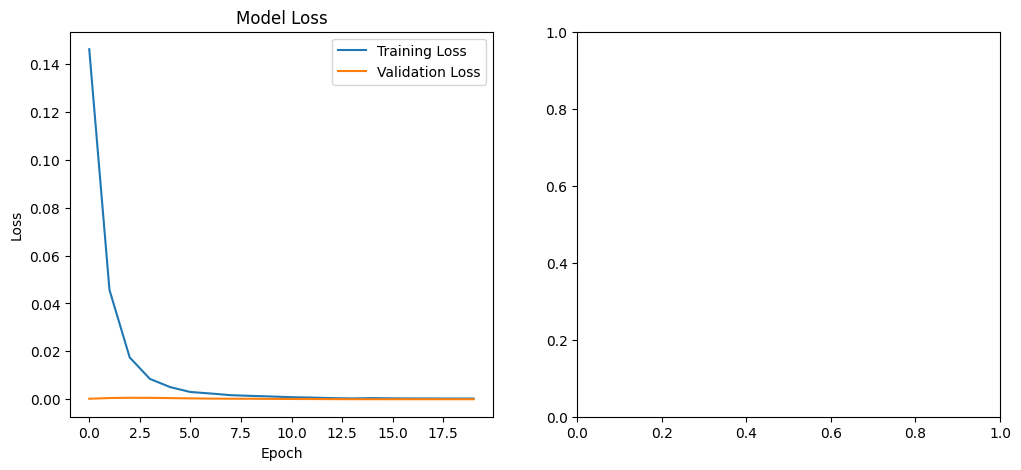

In [22]:
# Cell 7: Evaluate model and plot results
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Cell 8: Make predictions and save model
import json

def predict_cv_match(cv_text):
    # Preprocess text
    processed_text = tokenizer.texts_to_sequences([cv_text])
    processed_text = pad_sequences(processed_text, maxlen=100)
    
    # Get prediction
    score = model.predict(processed_text)[0][0]
    return score * 100  # Convert to percentage

# Save model and tokenizer
model.save('data/processed/cv/cv_matching_model.h5')
with open('data/processed/cv/tokenizer.json', 'w') as f:
    json.dump(tokenizer.to_json(), f)


2025-01-11 18:16:36,963 - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


In [1]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gc  # For garbage collection

# Force garbage collection
gc.collect()

0

In [2]:
# Cell 2: Load and prepare data
try:
    # Read CV data
    df = pd.read_csv('data/processed/cv/cv_texts.csv')
    print("Data loaded successfully")
    print("Number of documents:", len(df))
    
    # Initialize tokenizer
    tokenizer = Tokenizer(num_words=5000)
    
    # Fit tokenizer on texts
    texts = df['content'].values
    tokenizer.fit_on_texts(texts)
    
    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(texts)
    
    # Pad sequences
    maxlen = 100
    X = pad_sequences(sequences, maxlen=maxlen)
    
    print("Data preprocessing completed")
    print("Input shape:", X.shape)
    
except Exception as e:
    print(f"Error during data preparation: {str(e)}")

Data loaded successfully
Number of documents: 706
Data preprocessing completed
Input shape: (706, 100)


In [3]:
# Cell 3: Define model
try:
    # Model parameters
    vocab_size = min(5000, len(tokenizer.word_index) + 1)
    embedding_dim = 100
    
    # Build model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=maxlen),
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(embedding_dim, activation='tanh')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['cosine_similarity']
    )
    
    print(model.summary())
    
except Exception as e:
    print(f"Error building model: {str(e)}")

c:\Users\pngoc\OneDrive\Desktop\VNU IS\AI Project\CV-JD-Matching-System\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# Cell 4: Train model
try:
    # Define callbacks
    callbacks = [
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.2,
            patience=2,
            min_lr=1e-5
        ),
        EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    
    # Train model
    history = model.fit(
        X, X,  # Autoencoder style training
        validation_split=0.2,
        epochs=10,  # Reduced epochs
        batch_size=16,  # Reduced batch size
        callbacks=callbacks
    )
    
    print("Training completed successfully")
    
except Exception as e:
    print(f"Error during training: {str(e)}")

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 316ms/step - cosine_similarity: 0.1199 - loss: 1564618.2500 - val_cosine_similarity: 0.5367 - val_loss: 1859334.8750 - learning_rate: 0.0010
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - cosine_similarity: 0.4879 - loss: 1498459.6250 - val_cosine_similarity: 0.5639 - val_loss: 1859023.6250 - learning_rate: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - cosine_similarity: 0.5695 - loss: 1535423.1250 - val_cosine_similarity: 0.5781 - val_loss: 1858631.6250 - learning_rate: 0.0010
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step - cosine_similarity: 0.5759 - loss: 1507705.0000 - val_cosine_similarity: 0.5833 - val_loss: 1858329.0000 - learning_rate: 0.0010
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - cosine_similarity: 0.5719 - loss: 1470886.5000 - val_cosine_similarity: 0.5852 - val_loss: 1858190.3750 - learning_rate: 0.0010
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - cosine_similarity: 0.5768 - loss: 1

In [5]:
# Cell 5: Save model and tokenizer
import json
import os

try:
    # Create directories if they don't exist
    os.makedirs('data/processed/cv', exist_ok=True)
    
    # Save model
    model.save('data/processed/cv/cv_matching_model.h5')
    
    # Save tokenizer
    tokenizer_json = tokenizer.to_json()
    with open('data/processed/cv/tokenizer.json', 'w') as f:
        json.dump(tokenizer_json, f)
    
    print("Model and tokenizer saved successfully")
    
except Exception as e:
    print(f"Error saving model and tokenizer: {str(e)}")

Model and tokenizer saved successfully


In [7]:
# Cell 6A: Import and define matching function
import numpy as np

def calculate_cv_match(cv_text, job_description, model, tokenizer):
    """
    Calculate matching score between a CV and job description
    """
    try:
        # Preprocess texts
        cv_seq = tokenizer.texts_to_sequences([cv_text])
        jd_seq = tokenizer.texts_to_sequences([job_description])
        
        # Pad sequences
        maxlen = 100
        cv_pad = pad_sequences(cv_seq, maxlen=maxlen)
        jd_pad = pad_sequences(jd_seq, maxlen=maxlen)
        
        # Get embeddings
        cv_embedding = model.predict(cv_pad, verbose=0)
        jd_embedding = model.predict(jd_pad, verbose=0)
        
        # Calculate cosine similarity
        similarity = np.dot(cv_embedding[0], jd_embedding[0]) / (
            np.linalg.norm(cv_embedding[0]) * np.linalg.norm(jd_embedding[0])
        )
        
        return float(similarity * 100)  # Convert to percentage
        
    except Exception as e:
        print(f"Error calculating match: {str(e)}")
        return 0.0

In [8]:
# Cell 6B: Define example job description
job_description = """
We are looking for a Python Developer with:
- Strong experience in Python programming
- Knowledge of machine learning and data analysis
- Experience with web frameworks like Django or Flask
- Database experience (SQL, MongoDB)
- Good understanding of software development principles

Requirements:
- Bachelor's degree in Computer Science or related field
- 3+ years of professional Python development experience
- Experience with cloud platforms (AWS/Azure)
"""

print("Job Description loaded")

Job Description loaded


In [9]:
# Cell 6C: Process CVs and calculate matches
try:
    # Read CV data
    cv_df = pd.read_csv('data/processed/cv/cv_texts.csv')
    print(f"Loaded {len(cv_df)} CVs")
    
    # Calculate matches
    results = []
    for index, row in cv_df.iterrows():
        score = calculate_cv_match(row['content'], job_description, model, tokenizer)
        results.append({
            'filename': row['filename'],
            'match_score': score
        })
        print(f"Processed CV {index + 1}/{len(cv_df)}", end='\r')
    
    print("\nCV processing completed")
    
except Exception as e:
    print(f"Error processing CVs: {str(e)}")

Loaded 706 CVs
Processed CV 706/706
CV processing completed


In [10]:
# Cell 6D: Create and display results
try:
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by match score
    results_df = results_df.sort_values('match_score', ascending=False)
    
    # Display top matches
    print("\nTop CV Matches:")
    print("-" * 50)
    print(results_df.to_string(index=False))
    
    # Save results
    output_path = 'data/processed/cv/matching_results.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nResults saved to: {output_path}")
    
except Exception as e:
    print(f"Error handling results: {str(e)}")


Top CV Matches:
--------------------------------------------------
                                                        filename  match_score
                  Pratham Bhardwaj 9917103094 - Sonal Sharma.pdf    99.998832
                  Rohan Chaukrat (17104030) - Rohan Chaukrat.pdf    99.998230
                        Rabab_Zaidi_9917103138 - Rabab Zaidi.pdf    99.998063
                     Mitaali_Nagpal17103073 - Mitaali Nagpal.pdf    99.998015
               Shubham Aggarwal -16803006 - Shubham Aggarwal.pdf    99.997920
                                 PRIYA CHAWLA - Priya Chawla.pdf    99.997532
                      MrinalShukla9917103040 - mrinal shukla.pdf    99.997413
                                                    29990140.pdf    99.997360
                                                    24061629.pdf    99.997258
                                                    15821633.pdf    99.997228
                            RitikaJain17103269 - Ritika Jain.pdf    99.997

In [ ]:
# Cell 11: Lưu mô hình và các đối tượng cần thiết

# Lưu mô hình với định dạng Keras hiện đại
model.save('model.keras')  # Sử dụng định dạng .keras thay vì .h5

import joblib

# Lưu LabelEncoder và Tokenizer
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(tokenizer, 'tokenizer.joblib')

print("label_encoder.joblib, tokenizer.joblib và model.keras đã được lưu thành công.")

In [ ]:
# Cell 12: Vẽ các đường cong Loss và Accuracy

import matplotlib.pyplot as plt

# Vẽ Loss Curve
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Vẽ Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()